In [1]:
!nvidia-smi

Mon May  9 14:30:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:02:00.0 Off |                    0 |
| 23%   45C    P0    61W / 235W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 00000000:03:00.0 Off |                    0 |
| 24%   

In [2]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [3]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from scipy.spatial import distance
import seaborn as sns

In [4]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [5]:
data_folder = os.path.abspath('/mnt/cube/kai/data_processed/others')

results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
spec_file = os.path.join(data_folder, 'Mike_stims_specs_star.p')

In [6]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [7]:
spec_list = spec_df.spec.values.tolist()

In [8]:
h, w = spec_list[0].shape

In [9]:
print(h, w)

298 194


## make model and load weights

In [10]:
clear_session()

In [11]:
model=self_VGG()

In [12]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
model_outputs = model(resized)
feature_extractor = Model(model_inputs, model_outputs)

In [15]:
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/subj_classification/unsegmented_trainable/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

In [16]:
spec_df.head()

,wav,spec
0,/mnt/cube/mturvz/normed_motifs/all_motifs/A2-1...,"[[-0.89071786, -0.9061238, -0.94669884, -0.995..."
1,/mnt/cube/mturvz/normed_motifs/all_motifs/A3_+...,"[[-0.8159339, -0.8329322, -0.8805124, -0.95064..."
2,/mnt/cube/mturvz/normed_motifs/all_motifs/A62_...,"[[-0.7634527, -0.77958375, -0.8326478, -0.9381..."
3,/mnt/cube/mturvz/normed_motifs/all_motifs/B11_...,"[[-0.9130305, -0.9239519, -0.95564747, -1.0, -..."
4,/mnt/cube/mturvz/normed_motifs/all_motifs/B12_...,"[[-0.8242189, -0.84699905, -0.93398845, -1.0, ..."


## extract feature vector from each morph

In [18]:
feature_list = []
filename_list = []
for file, spec in spec_df.values:
    filename = file.split('/')[-1]
    spec_3d = np.stack([spec, spec, spec], axis = 2)
    spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
    feature_list.append(spec_features)
    filename_list.append(filename)

In [19]:
feature_df = pd.DataFrame()
feature_df['file'] = filename_list
feature_df['feature'] = feature_list

In [20]:
feature_df.to_pickle(os.path.join(data_folder, 'features.p'))

In [21]:
feature_df

,file,feature
0,A2-1_165_s_03_@1.wav,"[0.23406819, 2.5405354, 2.2078648, 0.022508122..."
1,A3_+_B3_165_s_13@1.wav,"[0.10900268, 2.9602292, 1.7962203, 0.029838173..."
2,A62_165_s_62_@1.wav,"[0.17468128, 2.4437788, 1.9142827, 0.02286469,..."
3,B11_165_s_17_@2.wav,"[0.23910336, 2.6656196, 1.8759729, 0.028502757..."
4,B12_165_s_48_@1.wav,"[0.12017513, 2.6294138, 2.0149107, 0.016509766..."
...,...,...
127,zogs5.wav,"[0.17947847, 2.7571292, 2.001831, 0.020562254,..."
128,zogs6.wav,"[0.30933028, 3.1307564, 2.9657114, 0.010584258..."
129,zogs7.wav,"[0.21143782, 3.1030667, 2.7812524, 0.016199486..."
130,zogs8.wav,"[0.34202155, 2.792184, 2.8602688, 0.035243444,..."


In [22]:
import scipy

In [23]:
scipy.spatial.distance.cosine

<function scipy.spatial.distance.cosine(u, v, w=None)>

In [24]:
similarity_df = pd.DataFrame(columns=filename_list, index=filename_list)

In [25]:
similarity_df

,A2-1_165_s_03_@1.wav,A3_+_B3_165_s_13@1.wav,A62_165_s_62_@1.wav,B11_165_s_17_@2.wav,B12_165_s_48_@1.wav,B18_211_s_58_@2.wav,B21_165_s_49_@2.wav,B22_165_s_22_@2.wav,B22_211_s_59_@1.wav,B2_165_s_03_@3.wav,...,ff1_G105_s_06_@1.wav,gg_G105_s_06_@2.wav,zogrA1.wav,zogs3.wav,zogs4.wav,zogs5.wav,zogs6.wav,zogs7.wav,zogs8.wav,zogwB1.wav
A2-1_165_s_03_@1.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3_+_B3_165_s_13@1.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A62_165_s_62_@1.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B11_165_s_17_@2.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B12_165_s_48_@1.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zogs5.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zogs6.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zogs7.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zogs8.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
for file, feature in zip(filename_list, feature_list):
    for subfile, subfeature in zip(filename_list, feature_list):
        similarity_df.loc[file, subfile] = scipy.spatial.distance.cosine(feature, subfeature)
#         similarity_df.loc[file, subfile] = rmse(feature, subfeature)

In [30]:
similarity_df.values.tolist()

[[0.0,
  0.006964921951293945,
  0.017876923084259033,
  0.008227229118347168,
  0.003117501735687256,
  0.020286917686462402,
  0.0034978389739990234,
  0.04134708642959595,
  0.01256328821182251,
  0.00398176908493042,
  0.2282348871231079,
  0.23624646663665771,
  0.23386996984481812,
  0.20738571882247925,
  0.21949368715286255,
  0.22030538320541382,
  0.218744158744812,
  0.2100447416305542,
  0.22577673196792603,
  0.21366214752197266,
  0.23232769966125488,
  0.0038874149322509766,
  0.00983285903930664,
  0.02175682783126831,
  0.00419163703918457,
  0.013355255126953125,
  0.013267159461975098,
  0.0024949312210083008,
  0.019294142723083496,
  0.0028854012489318848,
  0.007530868053436279,
  0.0037660598754882812,
  0.022561371326446533,
  0.022312402725219727,
  0.017253220081329346,
  0.013969123363494873,
  0.006205141544342041,
  0.0027627944946289062,
  0.009058952331542969,
  0.0068038105964660645,
  0.0003647804260253906,
  0.0067781805992126465,
  0.01568746566772461

In [33]:
similarity_df.to_pickle(os.path.join(data_folder, 'Mike_stims_feature_distance.p'))

<AxesSubplot:>

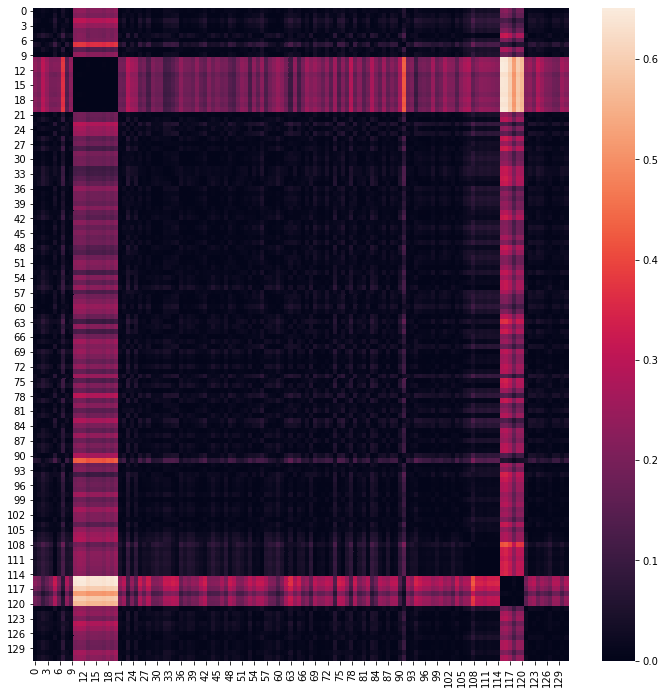

In [32]:
plt.figure(figsize=(12,12))
sns.heatmap(similarity_df.values.tolist())